<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/Camadas_Lineares_Ativacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camadas Lineares e Funções de Ativação



In [1]:
import torch
import torch.nn as nn

In [54]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, non_linearity=True):
        super().__init__()
        self.non_linearity = non_linearity
        self.layers = nn.ModuleList()
        in_dim = input_size

        # Hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(in_dim, hidden_size))
            in_dim = hidden_size

        # Output layer
        self.output_layer = nn.Linear(in_dim, 1)
        # self.activation_fn = nn.Sigmoid() if non_linearity else nn.Identity()
        self.activation_fn = nn.ReLU() if non_linearity else nn.Identity()

        # 🔧 Zero all biases
        for layer in self.layers:
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)

        if hasattr(self.output_layer, 'bias') and self.output_layer.bias is not None:
            nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = layer(x)
            if self.non_linearity:
                x = self.activation_fn(x)
            activations.append(x)
        out = self.output_layer(x)
        return out, activations

In [55]:
import numpy as np

from sklearn.datasets import make_circles
from torch.utils.data import DataLoader, TensorDataset

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
X, y = make_circles(n_samples=200, noise=0.1, factor=0.4, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MLP(input_size=X.shape[1], hidden_size=2, n_layers=5, non_linearity=True).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [58]:
import matplotlib.pyplot as plt

In [59]:
from tqdm import tqdm

100%|██████████| 10000/10000 [02:45<00:00, 60.60it/s]


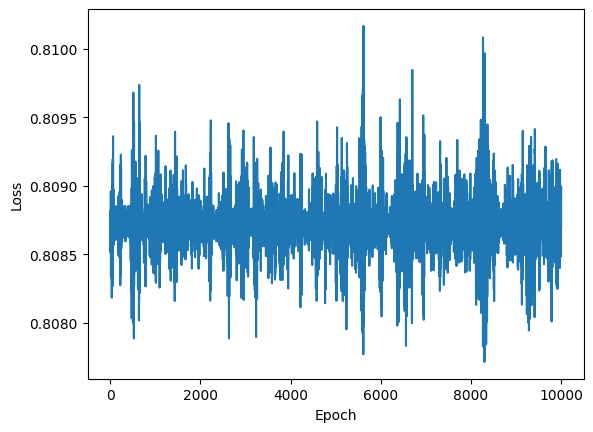

In [60]:
num_epochs = 10_000
# num_epochs = 1000
loss_logs = []

for epoch in tqdm(range(num_epochs)):

    # Start epoch loss
    running_loss = 0.0

    for b, (X_batch, y_batch) in enumerate(dataloader):

        # Forward pass
        outputs, _ = model(X_batch.to(device))
        loss = criterion(outputs, y_batch.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update epoch loss
    loss_logs.append(running_loss/b)

    # tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/b:.4f}")

# Plot loss
plt.plot(loss_logs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [61]:
@torch.no_grad()
def plot_decision_boundary(model, X, y, show_activations=False, resolution=0.01, cmap='cividis'):
    """
    Plot the decision boundary for a 2D torch model.

    Args:
        model: torch.nn.Module that outputs predictions or (pred, activations)
        X: torch.Tensor of shape (N, 2)
        y: torch.Tensor of shape (N,) or (N,1)
        show_activations: if True, also plot intermediate activations as subplots
        resolution: grid resolution for the mesh
        cmap: color map for contour plot
    """
    device = next(model.parameters()).device
    X, y = X.to(device), y.to(device)

    # Build grid
    x_min, x_max = X[:, 0].min().item(), X[:, 0].max().item()
    y_min, y_max = X[:, 1].min().item(), X[:, 1].max().item()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32, device=device)

    # Model prediction (handle models returning activations)
    output = model(grid)
    if isinstance(output, tuple):  # (y_pred, activations)
        Z, activations = output
    else:
        Z, activations = output, None

    # Convert logits to binary predictions
    if Z.ndim > 1 and Z.shape[1] == 1:
        Z = Z.squeeze(1)
    Z = torch.sigmoid(Z) if Z.dtype.is_floating_point else Z
    Z = (Z > 0.5).float()
    Z = Z.cpu().numpy().reshape(xx.shape)

    # Main plot
    contour = plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
    plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), s=10, label="Class 0")
    plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), s=10, label="Class 1")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x₀')
    plt.ylabel('x₁')
    plt.legend()

    # Optionally show activations
    for i, activation in enumerate(activations):
        n_neurons = activation.shape[1]
        fig, axes = plt.subplots(1, n_neurons, figsize=(4 * n_neurons, 4))
        if n_neurons == 1:
            axes = [axes]
        a = activation.detach().cpu().numpy()
        for i in range(n_neurons):
            Z = a[:, i].reshape(xx.shape)  # only first neuron
            axes[i].contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
            axes[i].set_title(f"Layer {i+1} activation")
            axes[i].set_xlabel('x₀')
            axes[i].set_ylabel('x₁')
        plt.tight_layout()

    plt.show()

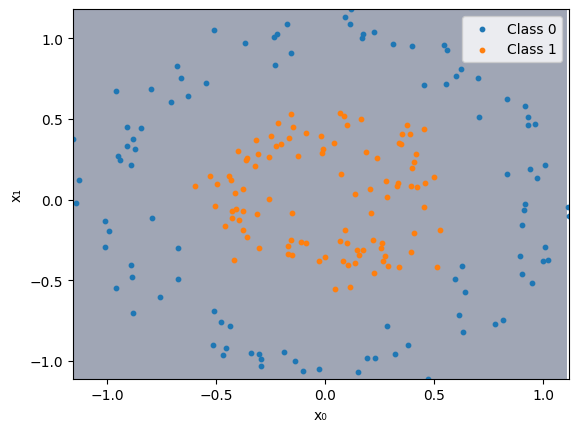

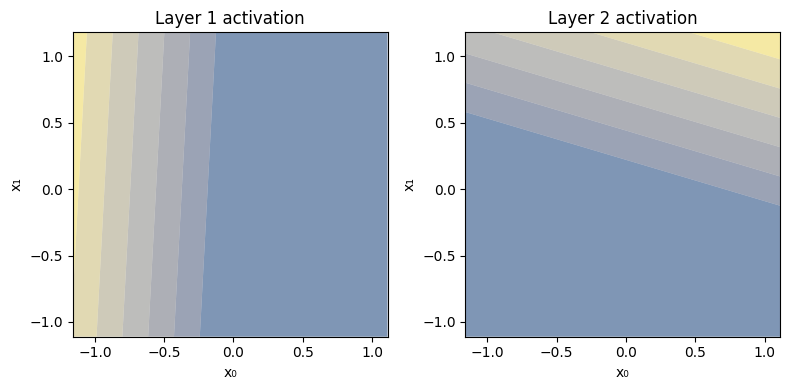

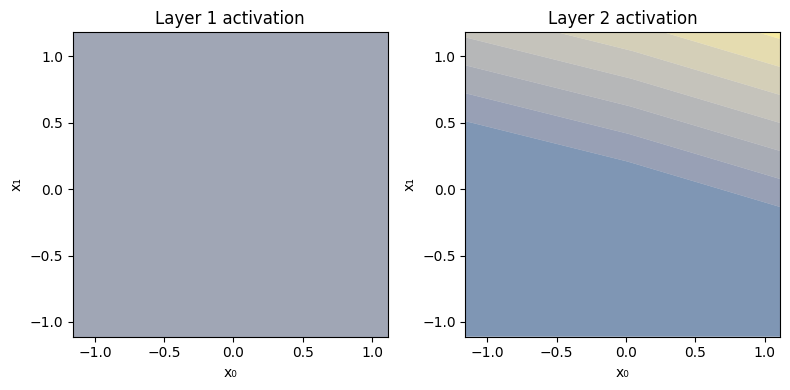

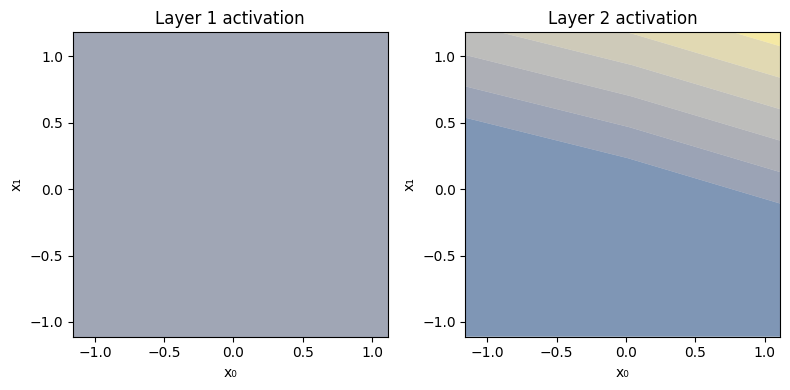

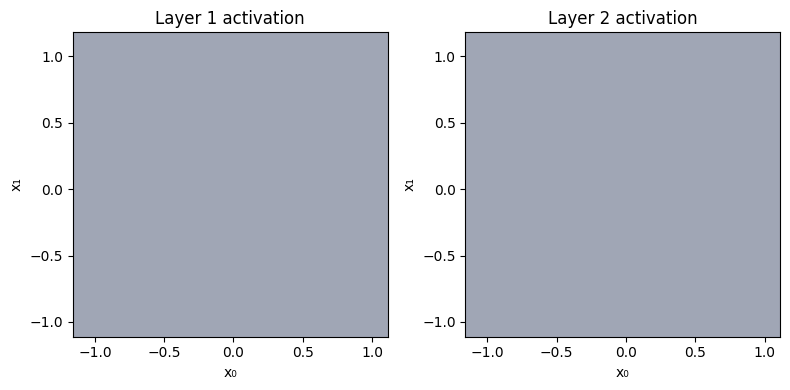

In [62]:
plot_decision_boundary(model, X, y[:,0], show_activations=True)